Here I will try and prove that my model isn't working. First, I will run my optimizer 3 times to see if I get different results.

Now I will compare how the mode matching compares to actually tracing the particle. I will also inspect these swarms to see that they make sense.




In [3]:
import itertools

from storageRingOptimizer import LatticeOptimizer
import numpy as np
from helperTools import *
import dill
import matplotlib.pyplot as plt
from ParticleClass import Swarm,Particle
from ParticleTracerLatticeClass import ParticleTracerLattice
import time
from SwarmTracerClass import SwarmTracer
from optimizerHelperFunctions import generate_Ring_And_Injector_Lattice

# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01074743 0.01867891 0.01761212 0.01024843 0.18664755]
# storage ring tuned params 2 optimum configuration: [0.64475991 0.60149558]
# cost: 0.92668415120023
# percent max flux multiplication: 7.3315848799770045
# scipy message: Optimization terminated successfully.



# ----------Solution-----------
# injector element spacing optimum configuration: nan
# storage ring tuned params 1 optimum configuration: [0.01002868 0.01852266 0.01876837 0.00984218 0.1864913 ]
# storage ring tuned params 2 optimum configuration: [0.3370546  0.68263976]
# cost: 0.6129659036716784
# percent max flux multiplication: 38.70340963283216
# scipy message: Optimization terminated successfully.
# ----------------------------

X=np.array([0.02054458, 0.0319046 , 0.01287383, 0.008     , 0.38994521])


tuning=None
PTL_Ring,PTL_Injector=generate_Ring_And_Injector_Lattice(X,tuning,standardMagnetErrors=True)

# XSpacing=[0.64475991 ,0.60149558]
# XLatticeSpace= XSpacing[:2]
# XInjectorSpace= XSpacing[2:]



optimizer=LatticeOptimizer(PTL_Ring,PTL_Injector)
optimizer.numParticlesFullSwarm=1000
# optimizer.numParticlesRing=50000
# optimizer.numParticlesInjector=1000
elementIndices=(0,6)
# ringTuningBounds = [(0.0, 1.5)]*2
# injectorTuningBounds = [(.01, .4), (.01, .4)]
# optimizer.catch_Optimizer_Errors(ringTuningBounds, elementIndices, tuning,'all')
# optimizer.initialize_Optimizer(elementIndices,tuning,'all',ringTuningBounds,injectorTuningBounds)
# optimizer.update_Ring_Lattice(XLatticeSpace)
# optimizer.update_Injector_Lattice(XInjectorSpace)


In [21]:
# %matplotlib tk
# optimizer.show_Floor_Plan(XSpacing)
# optimizer.floor_Plan_Cost(XSpacing)

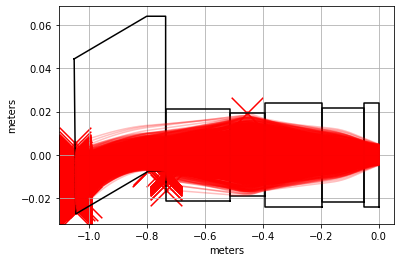

(271.36403180203666, 254.97463338209283)

In [4]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6
optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=True,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)
swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=True)
# print(swarmEnd.num_Particles())
swarmRingInitial = optimizer.swarmTracerRing.move_Swarm_To_Combiner_Output(swarmEnd, copySwarm=False,scoot=True)
optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=False,showTraceLines=True,traceLineAlpha=.25,showMarkers=True,finalCoords=True,showRelativeSurvival=False) #careful about which swarm
optimizer.swarmInjectorInitial.num_Particles(weighted=True),swarmRingInitial.num_Particles(weighted=True)

In [10]:
#trace through lattice
from helperTools import *
%matplotlib inline
import multiprocess as mp
def percentFluxMult(T,energyCons=True):
    fastMode=True
    optimizer.T=T
    swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, optimizer.T, parallel=False,
                            fastMode=fastMode, accelerated=True, copySwarm=True,energyCorrection=energyCons,stepsBetweenLogging=4)
    # PTL_Ring.show_Lattice(swarm=swarmTraced,showMarkers=True,showTraceLines=True,traceLineAlpha=.5)
    # print(swarmTraced.lattice_Flux())
    # print(sum([p.probability*p.revolutions for p in swarmTraced]))
    survivalFrac=swarmTraced.num_Particles(weighted=True)/optimizer.swarmInjectorInitial.num_Particles(weighted=True)
    maxFluxMult=T*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
    swarmFluxMult=swarmTraced.weighted_Flux_Multiplication()
    return 1e2*survivalFrac*swarmFluxMult/maxFluxMult

# TArr=np.logspace(np.log10(10.0/200.0),np.log10(100.0),50)
# results=tool_Parallel_Process(percentFluxMult,TArr,resultsAsArray=True)
percentFluxMult(10.0,energyCons=True)

31.075791196613782

In [21]:
xArr=np.linspace(.9,1.1,10)
coords=np.array(list(itertools.product(xArr,xArr)))
lens1,lens2=optimizer.latticeRing.elList[0],optimizer.latticeRing.elList[4]
def get_Survival(coord):
    lens1.set_fieldFact(coord[0])
    lens2.set_fieldFact(coord[1])
    return percentFluxMult(10.0)
vals=np.array([get_Survival(coord) for coord in coords])

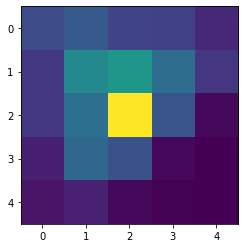

In [20]:
plt.imshow(np.array(vals).reshape((10,10)))

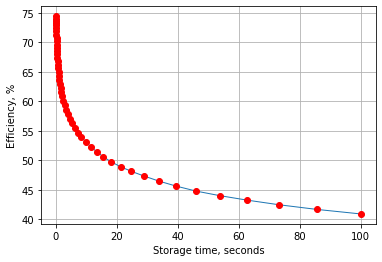

In [17]:
%matplotlib inline
resultsFluxMult=1e-2*results*TArr*optimizer.latticeRing.v0Nominal/optimizer.latticeRing.totalLength
# resultsFluxMult=resultsFluxMult/(results*1e-2)
# plt.figure(figsize=(13,8))
plt.plot(TArr,results,linewidth=1.0)
plt.plot(TArr,results,c='r',marker='o',linewidth=0.0)
plt.grid()
plt.xlabel('Storage time, seconds')
plt.ylabel('Efficiency, %')
plt.savefig('image_HexapoleCombinerSurvival3.jpg',dpi=100)
plt.show()

0.5300709840288027

In [15]:
flux=results[:,0]
fluxMax=results[:,1]
vacuumLine=(TArr*flux[0]/TArr[0])
maxLIne=(TArr*fluxMax[0]/TArr[0])
plt.scatter(TArr,flux/fluxMax)
plt.show()
plt.scatter(TArr,flux,label='simulation results')
plt.plot(TArr,vacuumLine,label='vacuum limited injected',c='r')
plt.plot(TArr,maxLIne,label='vacuum limited, ideal loading',c='g')
plt.ylabel('Flux multiplication')
plt.xlabel('Time, seconds')
plt.grid()
plt.legend()
plt.show()
flux[-1],fluxMax[0]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# look at energy conservation

In [55]:
TMaxE_Test=30.0
swarmTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmRingInitial, optimizer.h, TMaxE_Test, parallel=True,
                                                                    fastMode=True, accelerated=True, copySwarm=True)

In [56]:
particleEnergyTestList=[]
for particle in swarmTraced:
    if particle.clipped==False:
        particleFresh=Particle(qi=particle.qi,pi=particle.pi)
        particleEnergyTestList.append(particleFresh)
    if len(particleEnergyTestList)>=5:
        break
swarmE_Test=Swarm()
swarmE_Test.particles=particleEnergyTestList

In [59]:
t=time.time()
swarmE_TestTraced = optimizer.swarmTracerRing.trace_Swarm_Through_Lattice(swarmE_Test, optimizer.h, TMaxE_Test, parallel=True,
                                    fastMode=False, accelerated=True, copySwarm=True,energyCorrection=True,stepsBetweenLogging=8)
print(time.time()-t)

21.09089183807373


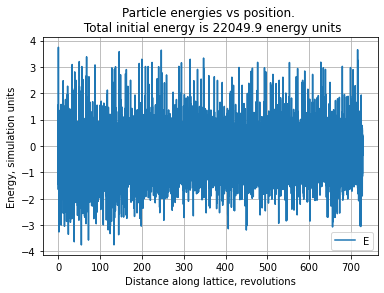

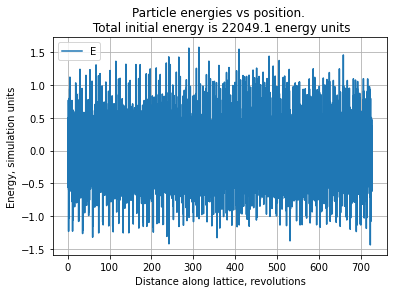

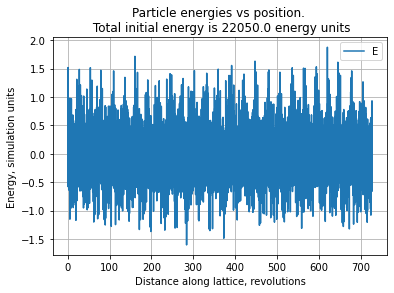

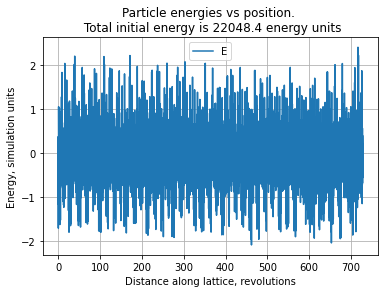

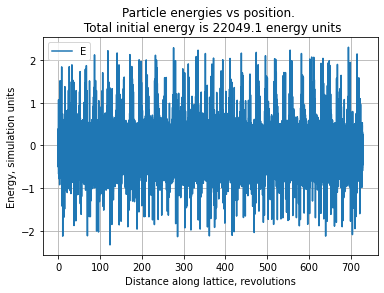

In [60]:
%matplotlib inline
for particle in swarmE_TestTraced:
    particle.plot_Energies(showOnlyTotalEnergy=True)
# swarmTraced.particles[0].plot_Energies(showOnlyTotalEnergy=True)
# p0Arr=swarmTraced.particles[0].p0Arr
# plt.plot(p0Arr)
# plt.show()

# make some nice plots

### Nice plots of injection

In [3]:
#trace through injector
# %matplotlib tk
# %matplotlib inline
fastMode=False
h=5e-6
optimizer.generate_Swarms()
swarm=optimizer.swarmInjectorInitial
swarmInjectorTraced = optimizer.swarmTracerInjector.trace_Swarm_Through_Lattice(
    swarm
    , h, 1.0, parallel=True,
    fastMode=fastMode, copySwarm=True,
    accelerated=True,energyCorrection=False,stepsBetweenLogging=4)

for i,particle in enumerate(swarmInjectorTraced):
    particle.i=i
swarmEnd = optimizer.move_Survived_Particles_In_Injector_Swarm_To_Origin(swarmInjectorTraced, copyParticles=True)
for particle1 in swarmEnd:
    for particle2 in swarmInjectorTraced:
        if particle1.i==particle2.i:
            particle2.clipped=False

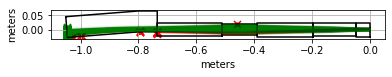

In [5]:
optimizer.latticeInjector.show_Lattice(swarm=swarmInjectorTraced,trueAspectRatio=True,showTraceLines=True,traceLineAlpha=.02,showMarkers=True,finalCoords=True,showRelativeSurvival=False,defaultMarkerSize=50,saveTitle='injectorImage')

In [61]:
survival=swarmEnd.num_Particles()/swarmInjectorTraced.num_Particles()
survival

0.924